In [1]:
import sympy as sp
from sympy import sin, cos, pi
# from sympy.interactive import printing
import pickle
import numpy as np
import scipy as sc
import scipy.interpolate
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct
import symbtools.modeltools as mt

In [13]:
x1, x2, x3 = xx = sp.symbols("x1, x2, x3")
k = sp.symbols("k")
m = 1; g=9.81; l=1; J=0.01
k_value = m*g*l/(J+m*l**2)
params = [(k, k_value)]

In [14]:
ff = sp.Matrix([[-x2*x3], [x1*x3], [-k*x1]])
ff

Matrix([
[-x2*x3],
[ x1*x3],
[ -k*x1]])

In [239]:
h = x1
N = 3

In [240]:
lie = []
for i in range(N):
    lie.append(st.lie_deriv(h, ff, xx, order=i))

q = sp.Matrix(lie)
q

Matrix([
[                x1],
[            -x2*x3],
[k*x1*x2 - x1*x3**2]])

In [241]:
Q = q.jacobian(xx)
Q

Matrix([
[           1,    0,        0],
[           0,  -x3,      -x2],
[k*x2 - x3**2, k*x1, -2*x1*x3]])

In [242]:
sp.print_latex(Q)

\left[\begin{matrix}1 & 0 & 0\\0 & - x_{3} & - x_{2}\\k x_{2} - x_{3}^{2} & k x_{1} & - 2 x_{1} x_{3}\end{matrix}\right]


In [243]:
Q.subs(x3,0)

Matrix([
[   1,    0,   0],
[   0,    0, -x2],
[k*x2, k*x1,   0]])

In [244]:
Q.subs(x1,0)

Matrix([
[           1,   0,   0],
[           0, -x3, -x2],
[k*x2 - x3**2,   0,   0]])

In [245]:
if Q.shape[0] == Q.shape[1]:
    print(Q.det())
    print(sp.solve(Q.det(), xx))

k*x1*x2 + 2*x1*x3**2
[(x1, 0, 0)]


In [255]:
sp.simplify(Q.det().subs(x2, 1-x1**2))

x1*(-k*(x1**2 - 1) + 2*x3**2)

In [246]:
sp.solve(sp.simplify(Q.det().subs(x2, 1-x1**2)), xx)

[(0, x2, x3),
 (-sqrt((k + 2*x3**2)/k), x2, x3),
 (sqrt((k + 2*x3**2)/k), x2, x3)]

In [247]:
print("gen. rank", st.generic_rank(Q))
print("gen. rank", st.generic_rank(Q.subs([(x1,0), (x3,0)])))
print("gen. rank", st.generic_rank(Q.subs([(x2,0), (x3,0)])))
print("gen. rank", st.generic_rank(Q.subs([(x1,0), (x2,0)])))
print("gen. rank", st.generic_rank(Q.subs([(x1,0)])))
print("gen. rank", st.generic_rank(Q.subs([(x2,0)])))
print("gen. rank", st.generic_rank(Q.subs([(x3,0)])))


gen. rank 3
gen. rank 2
gen. rank 2
gen. rank 2
gen. rank 2
gen. rank 3
gen. rank 3


In [248]:
Q.rank()

3

In [249]:
import adolc
from systems import *

In [250]:
system = InvPendulum2()
rhs = system.rhs
output = system.get_output
print("Output", system.h_symb)


def output(state):
    return state[1]

Tape_F = 0
Tape_H = 1

n = system.n
adolc.trace_on(Tape_F)
af = [adolc.adouble() for _ in range(n)]
for i in range(n):
    af[i].declareIndependent()
vf = rhs(0, af)
for a in vf:
    a.declareDependent()
adolc.trace_off()


adolc.trace_on(Tape_H)
ah = [adolc.adouble() for _ in range(n)]
for i in range(n):
    ah[i].declareIndependent()
vh = output(ah)
vh.declareDependent()
adolc.trace_off()

def autodiff(p0, d=2):
    lie = adolc.lie_gradientc(Tape_F, Tape_H, p0, d)
    return lie, np.linalg.matrix_rank(lie)

Output x2


In [251]:
p0 = [0, 1, 0.1]
Q.subs([(x, p) for x, p in zip(xx, p0)])

Matrix([
[       1,    0,  0],
[       0, -0.1, -1],
[k - 0.01,    0,  0]])

In [252]:
adolc.lie_scalarc(Tape_F, Tape_H, p0, 2)

array([ 1.  ,  0.  , -0.01])

In [253]:
autodiff(p0, 2)

(array([[ 0.  ,  0.1 ,  0.  ],
        [ 1.  ,  0.  , -0.01],
        [ 0.  ,  0.  , -0.2 ]]),
 3)

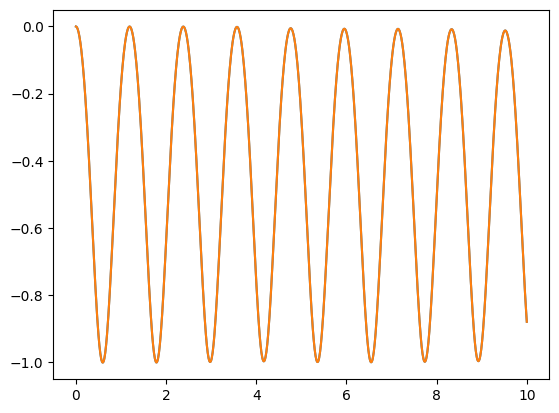

In [254]:
from scipy.integrate import solve_ivp
sol1 = solve_ivp(system.rhs, (0,10), y0=[1,0,0], t_eval=np.linspace(0,10,1000))
sol2 = solve_ivp(system.rhs, (0,10), y0=[-1,0,0], t_eval=np.linspace(0,10,1000))
import matplotlib.pyplot as plt
plt.plot(sol1.t, sol1.y[1], label="1,0,0")
plt.plot(sol2.t, sol2.y[1], label="-1,0,0")
plt.show()
assert all(sol1.y[1] == sol2.y[1])